In [1]:
%load_ext autoreload
%autoreload 2

# Data Preparation

In [2]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)
# Data Preparation
from api_helpers.game_stats_helpers import load_past_n_games
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns)
n_games_df = n_games_df.dropna()
merged_data = pd.merge(
    all_games_df[columns_a + columns_b], n_games_df, left_index=True, right_index=True
)


columns_x = columns_a + columns_b
columns_x = [column + "_x" for column in columns_x]
X = merged_data[columns_x]
columns_y = columns_a + columns_b
columns_y = [column + "_y" for column in columns_y]
y = merged_data[columns_y]
## Test Train Split
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Preloading Neural Network
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

y_final_true = all_games_df["WL_A"].loc[y_test.index].to_frame()
y_final_true.replace("W",1,inplace=True)
y_final_true.replace("L",0,inplace=True)
y_final_true.replace(" ",0,inplace=True)
y_final_true = list(y_final_true["WL_A"])

2024-07-21 18:30:46.659639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 18:30:46.668135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 18:30:46.677288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 18:30:46.680083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 18:30:46.687251: I tensorflow/core/platform/cpu_feature_guar

Loaded model from disk


2024-07-21 18:30:47.408200: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-21 18:30:47.408214: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: rohanbendapudi-Precision-3581
2024-07-21 18:30:47.408216: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: rohanbendapudi-Precision-3581
2024-07-21 18:30:47.408275: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-07-21 18:30:47.408283: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-07-21 18:30:47.408285: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1
/tmp/ipykernel_284158/3801391833.py:51: FutureWarning: Downcasting behavior in `replace` is deprecated and will b

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
<class 'int'>
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      3922
           1       0.80      0.97      0.87      5900

    accuracy                           0.83      9822
   macro avg       0.86      0.80      0.81      9822
weighted avg       0.85      0.83      0.82      9822



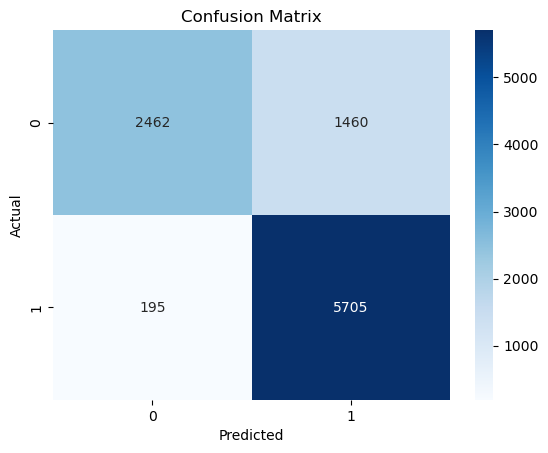

In [3]:
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# create an xgboost regression model

param = {'loss_function': 'MultiRMSE',"iterations": 500, "learning_rate": 0.1, "depth": 8,"verbose":False}

model = CatBoostRegressor(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(y_pred))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(type(y_pred_true[0]))


# Evaluate the model
print("Best Neural Network classification report:")
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()